In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle

In [5]:
file = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/pkls/sample_10k.pkl"
small_sample = pd.read_pickle(file)
small_sample_array = small_sample.to_numpy()

nevents = 10000
assert small_sample_array.shape == (2 * nevents, 9)

X = small_sample_array[:, :-1]
y = small_sample_array[:, -1]


In [15]:
small_sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,total_weight,target
0,575.675110,1.373108,17.0,0.031341,0.136947,-0.117397,1.0,0.556737,0.0
1,855.759460,1.259403,12.0,0.024994,0.095704,-0.307595,1.0,0.265614,0.0
2,1870.179565,0.443962,12.0,0.011368,0.121437,-0.493213,1.0,0.001397,0.0
3,709.712341,1.842305,15.0,0.029975,0.218998,-0.145374,2.0,0.291738,0.0
4,636.556763,-1.470679,16.0,0.030452,0.182767,-0.049136,2.0,0.756240,0.0


# Sample Inspection

In [6]:
def draw_pt_spectrum(pt_array, bins, user_weights = None, title = ' ', use_log = True, save = False):
    fig, ax = plt.subplots()
    if user_weights is None:
        ax.hist(pt_array, bins)
    else:
        ax.hist(pt_array, bins, weights = user_weights)
    ax.set_title(title + '$p_{T}$ Spectrum')
    ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel('Number of Jets')
    if use_log:
        ax.set_yscale('log')
    if save:
        file_title = title.replace(' ','_') + 'pt_distribution'
        if use_log:
            file_title = file_title + 'log'
        fig.savefig(file_title)
    fig.show()

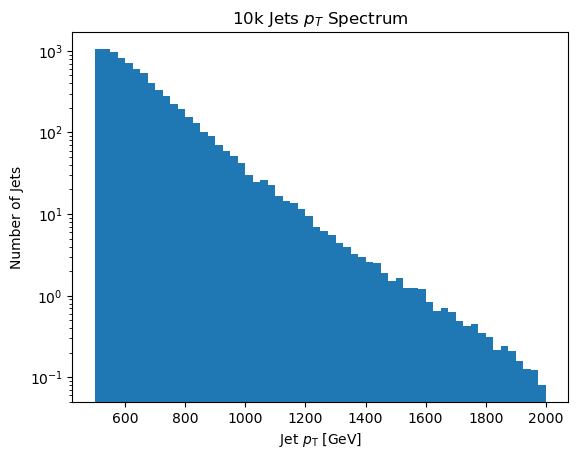

In [7]:
custom_bins = np.linspace(500, 2000, 61)
draw_pt_spectrum(small_sample_array[:,0], custom_bins, 
                 title = '10k Jets ', user_weights = small_sample_array[:,7], save = False)

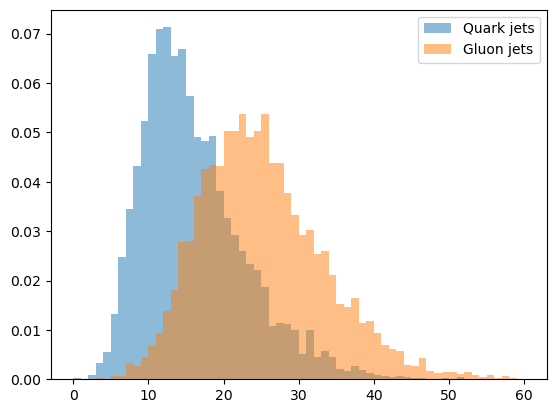

In [9]:
fig, ax = plt.subplots()
bin_edges = np.linspace(0, 60, 61)
ax.hist(X[:nevents][:, 2], bins=bin_edges, weights=X[:nevents][:, 7], alpha = 0.5, label="Quark jets", density=True)
ax.hist(X[nevents:][:, 2], bins=bin_edges, weights=X[nevents:][:, 7], alpha = 0.5, label="Gluon jets", density=True)
ax.legend()
fig.show()


# AdaBoost Training

In [10]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(43)

dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=1000,
                         learning_rate=0.1)

weight_idx = 7
bdt.fit(X_train[:, :5], y_train, sample_weight=X_train[:,weight_idx])


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=1000)

In [30]:
y_test_decisions = bdt.decision_function(X_test[:, :5])

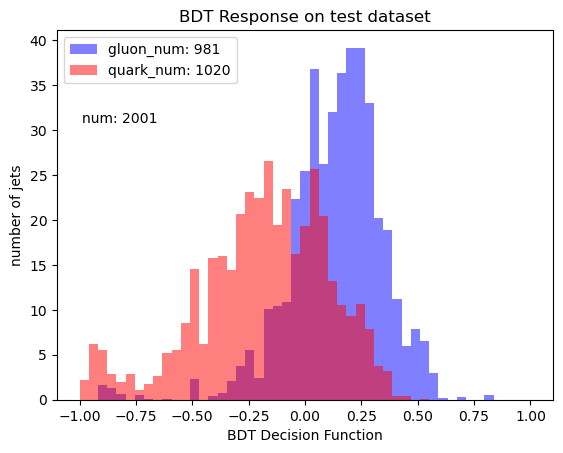

In [31]:
# Draw the BDT response 
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test[y_test_gluon_id][:, weight_idx], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test[y_test_quark_id][:, weight_idx], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"BDT Response on test dataset")
# plt.savefig("New_Training_flatpt.png", dpi=300)
plt.show()


In [35]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    # fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    # roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC BDT (area = %0.3f)'%(roc_auc))
    # plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label=r'ROC $N_{trk}$ (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC')
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


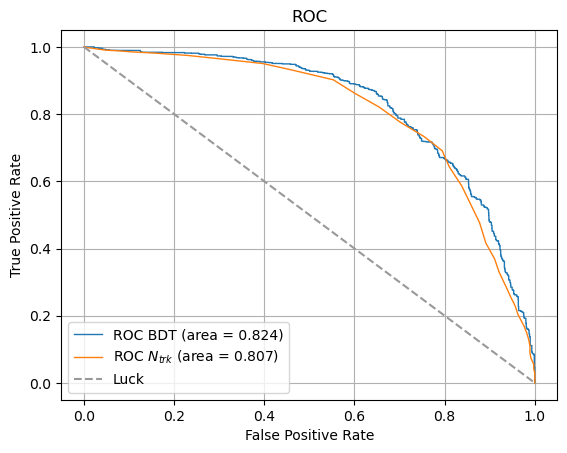

In [36]:
Draw_ROC(y_test, y_test_decisions, y_tmva=X_test[:,5] , y_ntrk=X_test[:,2], X_weight=X_test[:, weight_idx], features="All 5 features")

# Overtraining test

Text(0.5, 1.0, 'Overtraining test')

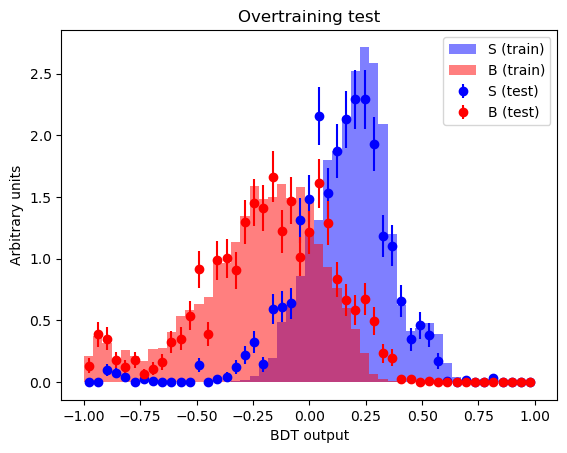

In [34]:
y_test_decisions = bdt.decision_function(X_test[:, :5])
y_train_decisions = bdt.decision_function(X_train[:, :5])

y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

bins=np.linspace(-1, 1, 50)
plt.hist(decisions[0], weights = X_train[:,weight_idx][np.where(y_train==1)],
            color='b', alpha=0.5, bins=bins,
            histtype='stepfilled', density=True,
            label='S (train)')
plt.hist(decisions[1], weights = X_train[:,weight_idx][np.where(y_train==0)],
            color='r', alpha=0.5,  bins=bins,
            histtype='stepfilled', density=True,
            label='B (train)')

hist, bins = np.histogram(decisions[2], weights=X_test[:,weight_idx][np.where(y_test==1)],
                            bins=bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')

hist, bins = np.histogram(decisions[3], weights=X_test[:,weight_idx][np.where(y_test==0)],
                            bins=bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")
